# Music Service Datawarehouse Design and User Engagement Analysis on AWS 

### Project Goal:



### Outlines:

1. Data Preprocessing
2. EDA
3. Feature Engineering
4. Modelling
5. Testing
6. Conclusion

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data Preprocessing

In this step, we will be loading data from json file and clean the data after analyzing the missing value in the dataset.

In [4]:
# Create spark session and load the dataframe

spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [5]:
# Create a view to leverage SQL to manipulate data
df.createOrReplaceTempView('logs')

In [6]:
# remove missing value in userid and sessionid
df = df.dropna(how = "any", subset = ["userId", "sessionId"])
df.count()

286500

In [7]:
# remove the userid with empty string
df = df.filter(df.userId!="")
df.count()

278154

In [8]:
# filter out the log out users
df = df.where(col('auth') != 'Logged Out')
df.count()

278154

## EDA

### Define Churn 

According to the dataset, the most obvioius variable here to show if the user is churn or not is the page. If they are at cancellelation confirmation status, it shows they are churn. 

In [9]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
# Show the unique page status and count.
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [11]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", get_time(df.ts))

In [12]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-09-30 17:01:57|
|    Five Ir

In [13]:
# observe the activity log of a user whose userid is 296
df.select(["userId", "page", "time", "level", "song", "sessionId"]).where(df.userId == "30").sort("time").show(100)

+------+---------------+-------------------+-----+--------------------+---------+
|userId|           page|               time|level|                song|sessionId|
+------+---------------+-------------------+-----+--------------------+---------+
|    30|       NextSong|2018-09-30 17:01:57| paid|           Rockpools|       29|
|    30|       NextSong|2018-09-30 17:06:34| paid|   Time For Miracles|       29|
|    30|       NextSong|2018-09-30 17:11:16| paid|Harder Better Fas...|       29|
|    30|       NextSong|2018-09-30 17:14:59| paid|Passengers (Old A...|       29|
|    30|Add to Playlist|2018-09-30 17:15:05| paid|                null|       29|
|    30|       NextSong|2018-09-30 17:18:04| paid|          Fuck Kitty|       29|
|    30|       NextSong|2018-09-30 17:20:18| paid|                Jade|       29|
|    30|       NextSong|2018-09-30 17:24:01| paid|   So-Called Friends|       29|
|    30|       NextSong|2018-09-30 17:28:07| paid|           Represent|       29|
|    30|       N

In [14]:
# add one more columns to show  if this user is churn or not

churn_users = df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_withchurn = df.withColumn("churn", df.userId.isin(churn_users_list))
df_withchurn.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|               time|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-09-30 17:01:57|false|
|Five Iron Frenzy|Logged In|    

## Analysis of Other Variables

In this step, we will be analyzing the features we have one by one to choose the suitable features for future modeling. Currently we have variables artist, gender, level, location, song, useragent, and time.

#### 1. relationship between churn and gender

In [15]:
df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").show()

+-----+------+-----+
|churn|gender|count|
+-----+------+-----+
|false|     M|   89|
|false|     F|   84|
| true|     F|   20|
| true|     M|   32|
+-----+------+-----+



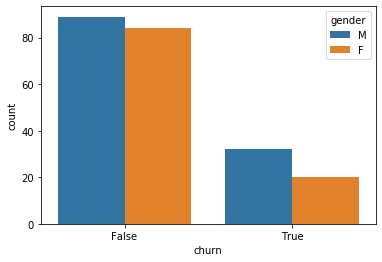

In [16]:
df_pd = df_withchurn.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()
sns.barplot(x='churn', y='count', hue='gender', data=df_pd)

#### 2. relationship between churn and page use

In [17]:
churn_count = df_withchurn.filter(df_withchurn.churn==1).count()
no_churn_count = df_withchurn.filter(df_withchurn.churn==0).count()

df_temp1 = df_withchurn.filter(df_withchurn.churn==1).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = df_withchurn.filter(df_withchurn.churn==0).filter(df_withchurn.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

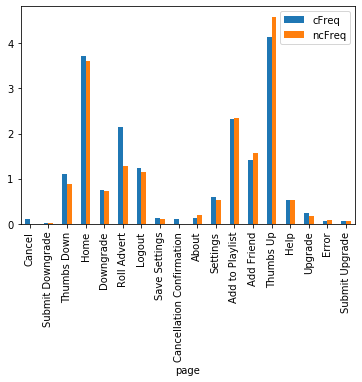

In [18]:
df_pd = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page")

#### 3. relationship between churn and level

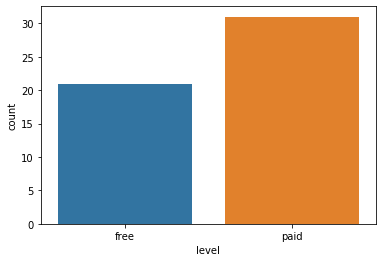

In [19]:
df_pd = df_withchurn.filter(df_withchurn.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

#### 4. relationship between churn and time span

In [20]:
df_withchurn.select("time").describe().show()

+-------+-------------------+
|summary|               time|
+-------+-------------------+
|  count|             278154|
|   mean|               null|
| stddev|               null|
|    min|2018-09-30 17:01:57|
|    max|2018-12-02 17:11:16|
+-------+-------------------+



In [21]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
df_withchurn = df_withchurn.withColumn("hour", get_hour(df_withchurn.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
df_withchurn = df_withchurn.withColumn("weekday", get_weekday(df_withchurn.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
df_withchurn = df_withchurn.withColumn("day", get_day(df_withchurn.ts))

In [22]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = df_withchurn.filter(df_withchurn.page == "NextSong").groupby("churn", time).count().orderBy(df_withchurn[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    df_pd[df_pd.churn==0].plot.bar(x=time, y='count', color='Blue', label='Not churn')
    df_pd[df_pd.churn==1].plot.bar(x=time, y='count', color='Red', label='Churn')

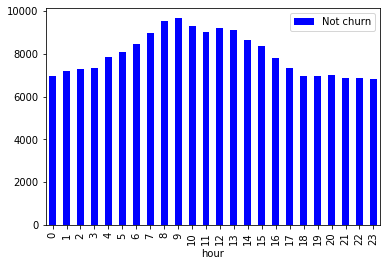

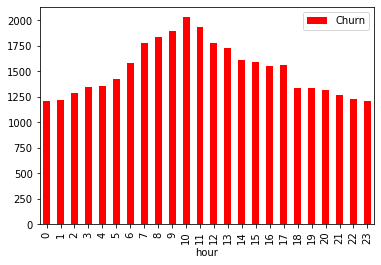

In [23]:
plot_cnt_by_churn("hour")


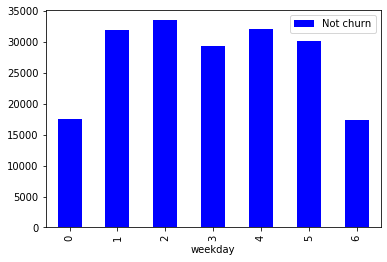

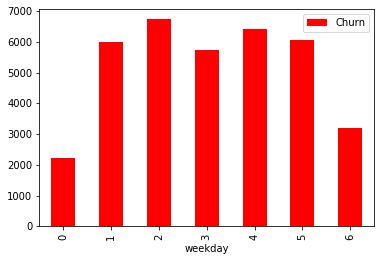

In [24]:
plot_cnt_by_churn("weekday")

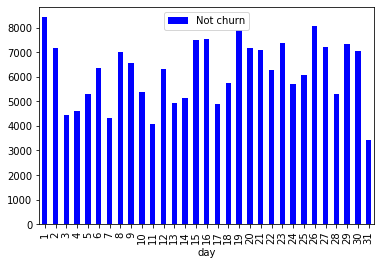

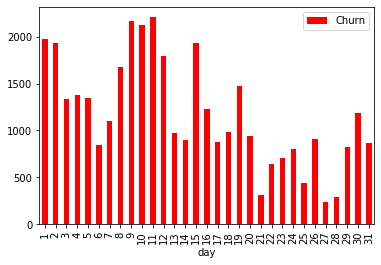

In [25]:
plot_cnt_by_churn("day")

#### 5.Show the distribution in operations in each session for churn user and non-churn user

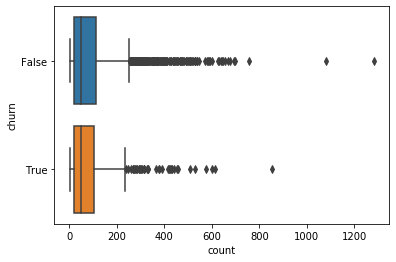

In [26]:
df_pd = df_withchurn.groupby("churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x='count', y='churn', orient="h", data=df_pd)

## Feature Engineering 

Based on previous analysis on all variables, we will be choosing the features for future use.

feature 1: gender

feature 2: days after registration

feature 3: avg/min/max time per session

feature 4: number of song per session

feature 5: number of session

feature 6: level

feature 7: frequency of use of pages

feature 8: how many singers have the user heard

#### Feature 1: gender

In [27]:
user_gender = df_withchurn.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [28]:
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



#### Feature 2: days after registration

In [29]:
user_max_ts = df_withchurn.groupBy("userId").max("ts").sort("userId")
user_reg_ts = df_withchurn.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [30]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



#### Feature 3: avg/min/max time per session

In [31]:
user_session_time = df_withchurn.groupby("userId", "sessionId").agg(((max(df_withchurn.ts)-min(df_withchurn.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [32]:
user_session_time_stat.show(5)


+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows



#### Feature 4: number of song per session

In [33]:
user_session_songs = df_withchurn.filter(df_withchurn.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [34]:
user_session_songs_avg.show(5)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



#### Feature 5: number of session

In [35]:
user_session_count = df_withchurn.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

In [36]:
user_session_count.show(5)


+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



#### Feature 6: frequency of use of pages

In [37]:
user_paid = df_withchurn.groupby("userId", "level").agg(max(df_withchurn.ts).alias("finalTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

In [38]:
user_recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



#### Feature 7: how many singers have the user heard

In [39]:
# get all the type of page
page_list = [(row['page']) for row in df_withchurn.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = df_withchurn.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")


for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = df_withchurn.filter(df_withchurn.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [40]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [41]:
user_page_view_freq.show(5)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+----------------

#### Feature 8: how many singers have they heard

In [42]:
user_artist_count = df_withchurn.filter(df_withchurn.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")

In [43]:
user_artist_count.show(5)


+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



#### Obtain the label

In [44]:
user_churn = df_withchurn.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



#### Integrate all the features

In [45]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [46]:
# prepare the final dataframe to join all the other features
df_final = df_withchurn.select("userId").dropDuplicates()

In [47]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [48]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [49]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+------------------+------------------+-----------------+------------------+------------------+------------+------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|aritstCount|churn|
+------+------------------+-------------

## Modelling

In this step, we will build a classification model for predicting the user churn.
1. split the training and testing set
2. Logistics model
3. gradient boosting tree model
4. Parameter tunnning

In [50]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [51]:
out_path = "final_data.csv"

In [82]:
df_final.write.save(out_path, format="csv", header=True)

In [51]:
df_final = spark.read.csv(out_path, header=True)
df_final.persist()

DataFrame[userId: string, regDay: string, avgSessionTime: string, minSessionTime: string, maxSessionTime: string, avgSessionSongs: string, sessionCount: string, gender: string, level: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, aritstCount: string, churn: string]

In [53]:
# convert the dataframe to a numeric dataframe
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [54]:
# Put the features to be trained into a vector
assembler = VectorAssembler(inputCols=df_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_final)

In [55]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [56]:
data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))


In [57]:
# split testing set and training set
train, validation = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [58]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lr.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lr = crossval.fit(train)

In [59]:
cvModel_lr.avgMetrics


[0.7164387554684748,
 0.7429529263764336,
 0.7346751249406116,
 0.7164387554684748,
 0.7395371897918093,
 0.7157769898338133,
 0.7164387554684748,
 0.7157769898338133,
 0.6737959352566523,
 0.7164387554684748,
 0.7072991396900592,
 0.6553539969948639]

In [60]:
gbt = GBTClassifier()

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter,[3, 10, 20]) \
    .addGrid(gbt.maxDepth,[2, 4, 6, 8]) \
    .build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_gbt = crossval_gbt.fit(train)

In [61]:
cvModel_gbt.save('cvModel_gbt.model')


In [62]:
cvModel_gbt.avgMetrics


[0.676012956530198,
 0.6669807398120275,
 0.6511408950389214,
 0.6403690396266642,
 0.6983124480350293,
 0.6695460799949964,
 0.6511408950389214,
 0.6403690396266642,
 0.7107983034618548,
 0.684555154127087,
 0.6511408950389214,
 0.6403690396266642]

In [63]:
stratified_train = train.sampleBy('label', fractions={0: 99/349, 1: 1.0}).cache()
stratified_train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   50|
|  0.0|   50|
+-----+-----+



#### Logistics regression

In [64]:
lrs =  LogisticRegression()
paramGrid = ParamGridBuilder() \
    .addGrid(lrs.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
    .addGrid(lrs.regParam,[0.0, 0.05, 0.1]) \
    .build()

crossval_lrs = CrossValidator(estimator=lrs,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_lrs = crossval_lrs.fit(stratified_train)
cvModel_lrs.avgMetrics

[0.6168108096212671,
 0.7100569183902518,
 0.758423856463072,
 0.6168108096212671,
 0.7276028256420414,
 0.7492711775477512,
 0.6168108096212671,
 0.7492711775477512,
 0.763705430372097,
 0.6168108096212671,
 0.7600927790401475,
 0.6968091007350448]

In [66]:
cvModel_lr.save('cvModel_lrs.model')

#### Gradient Boosting Tree

In [67]:
gbts = GBTClassifier()
paramGrid = ParamGridBuilder() \
    .addGrid(gbts.maxIter,[3, 10, 20]) \
    .addGrid(gbts.maxDepth,[2, 4, 6, 8]) \
    .build()
crossval_gbts = CrossValidator(estimator=gbts,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
cvModel_gbts = crossval_gbts.fit(stratified_train)
cvModel_gbts.avgMetrics

[0.4841275907229317,
 0.490376219165313,
 0.4956264761676009,
 0.4956264761676009,
 0.5016026739801552,
 0.4881367486553265,
 0.4956264761676009,
 0.4956264761676009,
 0.5711176316246549,
 0.4881367486553265,
 0.4956264761676009,
 0.4956264761676009]

In [191]:
results = cvModel_lr.transform(validation)

In [69]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

1.0
0.5
0.6666666666666666


In [71]:
cvModel_gbts.save('cvModel_gbts.model')


In [70]:
results = cvModel_gbts.transform(validation)

In [72]:
tp = results.filter("label = 1 and prediction = 1").count()
fp = results.filter("label = 0 and prediction = 1").count()
fn = results.filter("label = 1 and prediction = 0").count()
precision = tp / (tp + fp) 
recall = tp / (tp + fn)
f1 = 2*precision*recall / (precision+recall)
print(precision)
print(recall)
print(f1)

0.4
1.0
0.5714285714285715


In [72]:
df_final.columns

['userId',
 'regDayNum',
 'avgSessionTimeNum',
 'minSessionTimeNum',
 'maxSessionTimeNum',
 'avgSessionSongsNum',
 'sessionCountNum',
 'genderNum',
 'levelNum',
 'freqSubmitDowngradeNum',
 'freqThumbsDownNum',
 'freqHomeNum',
 'freqDowngradeNum',
 'freqRollAdvertNum',
 'freqLogoutNum',
 'freqSaveSettingsNum',
 'freqAboutNum',
 'freqSettingsNum',
 'freqAddtoPlaylistNum',
 'freqAddFriendNum',
 'freqNextSongNum',
 'freqThumbsUpNum',
 'freqHelpNum',
 'freqUpgradeNum',
 'freqErrorNum',
 'freqSubmitUpgradeNum',
 'aritstCountNum',
 'churnNum']

## Prediction Using Redshift data 

In [307]:
"""
connect to redshift
"""
import configparser
import psycopg2
from getpass import getpass

config = configparser.ConfigParser()
config.read('../1_DataWarehouse/dwh.cfg')
KEY                    = config.get('AWS','KEY')
SECRET                 = config.get('AWS','SECRET')

conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

In [186]:
redshift_df = pd.read_sql("select * from users", con = conn)
redshift_df.head()

,user_id,first_name,last_name,gender,level,registration
0,101,Jayden,Fox,M,free,2018-11-01 00:53:32.796
1,86,Aiden,Hess,M,free,2018-10-29 16:03:45.796
2,80,Tegan,Levine,F,free,2018-10-29 06:25:56.796
3,100,Adler,Barrera,M,free,2018-10-29 17:59:43.796
4,53,Celeste,Williams,F,free,2018-11-01 13:05:28.796


In [243]:
import pyspark.sql.functions as F
redshift_user = redshift_df.user_id.tolist()

redshift_records = df_final.filter(F.col('userId').isin(redshift_user)).orderBy('userId')
redshift_records.show(3)

+------+---------+-----------------+-----------------+-----------------+------------------+---------------+---------+--------+----------------------+-----------------+-----------+----------------+-----------------+-------------+-------------------+------------+---------------+--------------------+----------------+---------------+---------------+-----------+--------------+------------+--------------------+--------------+--------+
|userId|regDayNum|avgSessionTimeNum|minSessionTimeNum|maxSessionTimeNum|avgSessionSongsNum|sessionCountNum|genderNum|levelNum|freqSubmitDowngradeNum|freqThumbsDownNum|freqHomeNum|freqDowngradeNum|freqRollAdvertNum|freqLogoutNum|freqSaveSettingsNum|freqAboutNum|freqSettingsNum|freqAddtoPlaylistNum|freqAddFriendNum|freqNextSongNum|freqThumbsUpNum|freqHelpNum|freqUpgradeNum|freqErrorNum|freqSubmitUpgradeNum|aritstCountNum|churnNum|
+------+---------+-----------------+-----------------+-----------------+------------------+---------------+---------+--------+--------

In [244]:
# Put the features to be trained into a vector
assembler = VectorAssembler(inputCols=redshift_records.columns[1:-1], outputCol="NumFeatures")
redshift_data = assembler.transform(redshift_records)
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(redshift_data )
redshift_data = scalerModel.transform(redshift_data )
redshift_data = redshift_data.select(redshift_data.churnNum.alias("label"), redshift_data.ScaledNumFeatures.alias("features"))


In [245]:
results = cvModel_lr.transform(redshift_data)
results.show(3)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[1.39910932508894...|[3.48087851610371...|[0.97013878090633...|       0.0|
|  0.0|[1.75349406776993...|[3.65322107146591...|[0.97474670663004...|       0.0|
|  1.0|[1.45866273392983...|[2.94811085506899...|[0.95017412619333...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 3 rows



In [294]:
a = results.select('prediction').toPandas().reset_index()
b = df_final.filter(F.col('userId').isin(redshift_user)).orderBy('userId').select('userId').toPandas().reset_index()
prediction = pd.merge(a,b, on = 'index')
prediction['prediction'] = prediction['prediction'].apply(lambda x: int(x))
prediction['userId'] = prediction['userId'].apply(lambda x: int(x))


In [295]:
prediction.head(5)

,index,prediction,userId
0,0,0,10
1,1,0,100
2,2,0,101
3,3,0,11
4,4,0,12


## Save back to Redshift

In [309]:
# create table user_prediction
create_table = ("""  CREATE TABLE IF NOT EXISTS user_prediction
                                            (user_id         INTEGER,
                                            prediction       INTEGER
                                            ); """)

drop_table = "DROP TABLE IF EXISTS user_prediction"

insert_table = ("""  COPY  user_prediction FROM 's3://viviensparkify/prediction.csv'
                            CREDENTIALS 'aws_access_key_id={};aws_secret_access_key={}'
                            csv
                            IGNOREHEADER 1
                            """).format(KEY,SECRET)

cur.execute(drop_table)
conn.commit()

cur.execute(create_table)
conn.commit()

# save dataframe to S3 

from io import StringIO # python3; python2: BytesIO 
import boto3

file_name = "prediction.csv"
prediction[['userId','prediction']].to_csv(file_name,index=False)
s3 = boto3.resource('s3',                       
                    aws_access_key_id=KEY,
                    aws_secret_access_key=SECRET)
s3.meta.client.upload_file(file_name, 'viviensparkify', 'prediction.csv')

# LOAD S3 csv to Redshift

cur.execute(insert_table)
conn.commit()

print("Copy executed fine!")

conn.close()


Copy executed fine!


## Conclusion

Based on the model above, we found that the gradient boosting tree's performance is much better than logistics regression.

In [266]:
prediction[['userId','prediction']]

,userId,prediction
0,10,0.0
1,100,0.0
2,101,0.0
3,11,0.0
4,12,0.0
...,...,...
91,95,0.0
92,96,0.0
93,97,0.0
94,98,0.0
